In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [71]:
fear_greed = pd.read_csv("/content/fear_greed_index.csv")
trader_data = pd.read_csv("/content/historical_data.csv")

In [72]:
fear_greed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [73]:
trader_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [74]:
# Convert date columns to datetime if not already done
fear_greed['date'] = pd.to_datetime(fear_greed['date'])

# Handle the "Timestamp IST" conversion with correct format (day-first)
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'],
                                            dayfirst=True,  # Important for day-month-year format
                                            format='mixed')  # Allows flexible parsing

# Extract date component for merging
trader_data['date'] = trader_data['Timestamp IST'].dt.date
trader_data['date'] = pd.to_datetime(trader_data['date'])

# Verify conversions
print("Fear/Greed date range:", fear_greed['date'].min(), "to", fear_greed['date'].max())
print("Trader data date range:", trader_data['date'].min(), "to", trader_data['date'].max())


Fear/Greed date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Trader data date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


In [75]:
# 1. Data Exploration

print("Fear/Greed Index Value Ranges:")
print(fear_greed.groupby('classification')['value'].describe())

print("\nTrader Performance Summary:")
print(trader_data['Closed PnL'].describe())

Fear/Greed Index Value Ranges:
                count       mean       std   min   25%   50%    75%   max
classification                                                           
Extreme Fear    508.0  18.273622  4.699441   5.0  14.0  20.0  22.00  24.0
Extreme Greed   326.0  82.116564  6.532657  75.0  76.0  80.0  87.75  95.0
Fear            781.0  34.184379  6.092182  25.0  28.0  34.0  40.00  44.0
Greed           633.0  65.846761  6.246282  55.0  61.0  66.0  72.00  74.0
Neutral         396.0  49.964646  2.645993  45.0  48.0  50.0  52.00  54.0

Trader Performance Summary:
count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64


In [76]:
# 2. Daily Aggregation and Merging

# Create daily aggregates from trader data
daily_trader_perf = trader_data.groupby('date').agg({
    'Closed PnL': ['mean', 'median', 'sum', 'count'],
    'Size USD': 'sum',
    'Account': pd.Series.nunique
}).reset_index()
daily_trader_perf.columns = ['date', 'mean_pnl', 'median_pnl', 'total_pnl', 'trade_count', 'total_volume', 'unique_traders']

In [77]:
# Merge with fear/greed data
merged_data = pd.merge(daily_trader_perf, fear_greed, on='date', how='inner')

In [78]:
# 3. Sentiment Analysis Visualization

plt.figure(figsize=(15, 12))

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

Text(0, 0.5, 'Count')

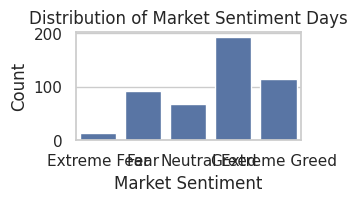

In [79]:
# Plot 1: Market Sentiment Distribution
plt.subplot(3, 2, 1)
sns.countplot(x='classification', data=merged_data, order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Distribution of Market Sentiment Days')
plt.xlabel('Market Sentiment')
plt.ylabel('Count')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Extreme Fear'),
  Text(1, 0, 'Fear'),
  Text(2, 0, 'Neutral'),
  Text(3, 0, 'Greed'),
  Text(4, 0, 'Extreme Greed')])

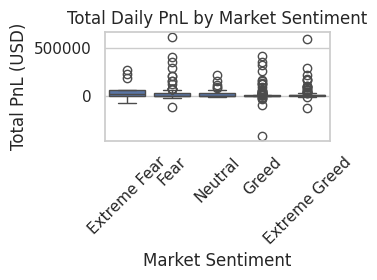

In [80]:
# Plot 2: Total PnL by Sentiment
plt.subplot(3, 2, 2)
sns.boxplot(x='classification', y='total_pnl', data=merged_data,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Total Daily PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Total PnL (USD)')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Extreme Fear'),
  Text(1, 0, 'Fear'),
  Text(2, 0, 'Neutral'),
  Text(3, 0, 'Greed'),
  Text(4, 0, 'Extreme Greed')])

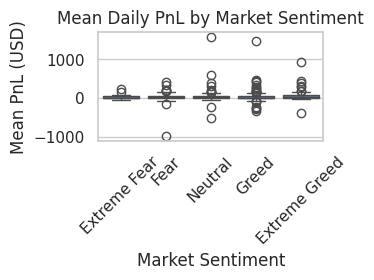

In [81]:
# Plot 3: Mean PnL by Sentiment
plt.subplot(3, 2, 3)
sns.boxplot(x='classification', y='mean_pnl', data=merged_data,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Mean Daily PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Mean PnL (USD)')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Extreme Fear'),
  Text(1, 0, 'Fear'),
  Text(2, 0, 'Neutral'),
  Text(3, 0, 'Greed'),
  Text(4, 0, 'Extreme Greed')])

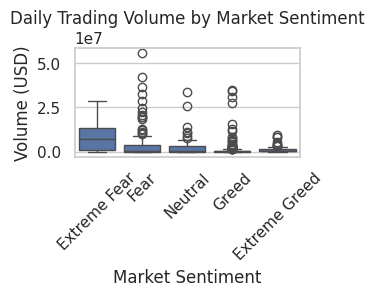

In [82]:
# Plot 4: Trading Volume by Sentiment
plt.subplot(3, 2, 4)
sns.boxplot(x='classification', y='total_volume', data=merged_data,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Daily Trading Volume by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Volume (USD)')
plt.xticks(rotation=45)

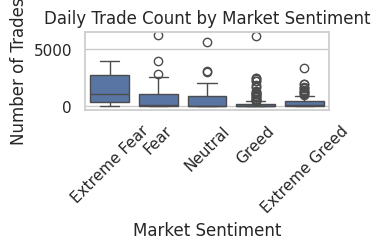

In [83]:
# Plot 5: Trade Count by Sentiment
plt.subplot(3, 2, 5)
sns.boxplot(x='classification', y='trade_count', data=merged_data,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Daily Trade Count by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [84]:
# 4. Correlation Analysis

# Create numerical sentiment mapping
sentiment_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
merged_data['sentiment_score'] = merged_data['classification'].map(sentiment_map)

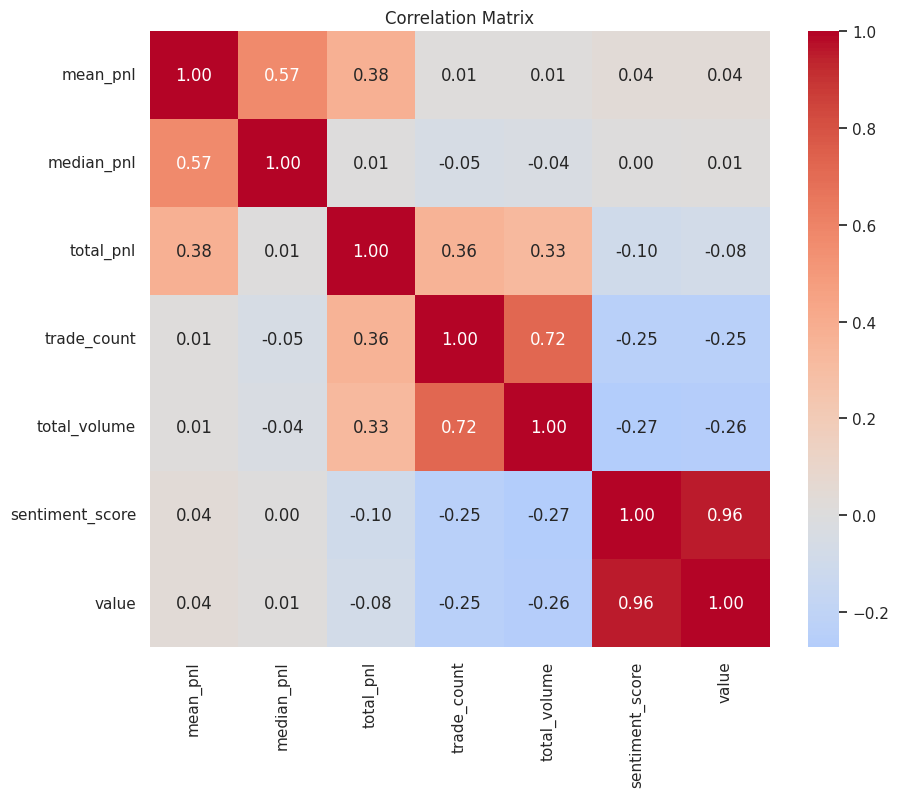

In [85]:
# Calculate correlations
correlation_matrix = merged_data[['mean_pnl', 'median_pnl', 'total_pnl', 'trade_count',
                                 'total_volume', 'sentiment_score', 'value']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [86]:
# 5. Statistical Testing

print("\nStatistical Significance Testing:")
sentiment_groups = merged_data.groupby('classification')['total_pnl'].apply(list)

# Compare Extreme Fear vs Extreme Greed
extreme_fear = sentiment_groups.get('Extreme Fear', [])
extreme_greed = sentiment_groups.get('Extreme Greed', [])

if extreme_fear and extreme_greed:
    t_stat, p_val = stats.ttest_ind(extreme_fear, extreme_greed, equal_var=False)
    print(f"Extreme Fear vs Extreme Greed: t-stat={t_stat:.2f}, p-value={p_val:.4f}")


Statistical Significance Testing:
Extreme Fear vs Extreme Greed: t-stat=1.04, p-value=0.3160


In [87]:
# Compare Fear vs Greed
fear = sentiment_groups.get('Fear', [])
greed = sentiment_groups.get('Greed', [])

if fear and greed:
    t_stat, p_val = stats.ttest_ind(fear, greed, equal_var=False)
    print(f"Fear vs Greed: t-stat={t_stat:.2f}, p-value={p_val:.4f}")

Fear vs Greed: t-stat=2.32, p-value=0.0217


Text(0, 0.5, 'Index Value')

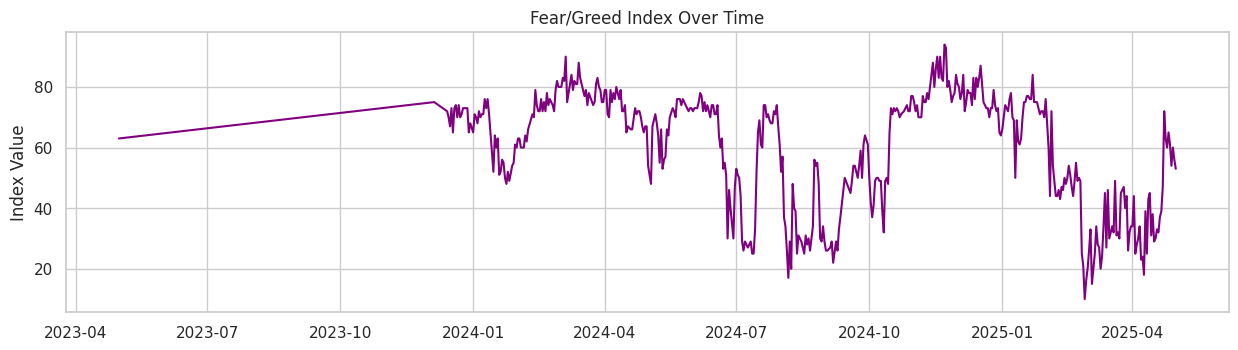

In [88]:
# 6. Time Series Analysis

plt.figure(figsize=(15, 8))

# Plot Fear/Greed Index
plt.subplot(2, 1, 1)
plt.plot(merged_data['date'], merged_data['value'], color='purple')
plt.title('Fear/Greed Index Over Time')
plt.ylabel('Index Value')

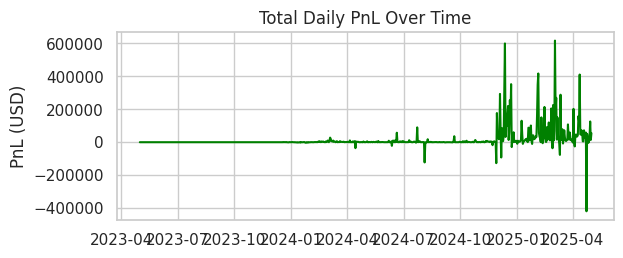

In [89]:
# Plot Total PnL
plt.subplot(2, 1, 2)
plt.plot(merged_data['date'], merged_data['total_pnl'], color='green')
plt.title('Total Daily PnL Over Time')
plt.ylabel('PnL (USD)')

plt.tight_layout()
plt.show()

In [90]:
# 7. Trader-Level Performance Analysis

# Calculate daily performance by trader
trader_daily = trader_data.groupby(['date', 'Account']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Coin': 'count'
}).reset_index()
trader_daily.columns = ['date', 'account', 'daily_pnl', 'daily_volume', 'trade_count']

In [91]:
# Merge with sentiment data
trader_sentiment = pd.merge(trader_daily, fear_greed, on='date')

# Analyze top performers in different sentiment regimes
top_traders = trader_sentiment.groupby(['account', 'classification']).agg({
    'daily_pnl': 'mean',
    'daily_volume': 'mean',
    'trade_count': 'mean'
}).reset_index()

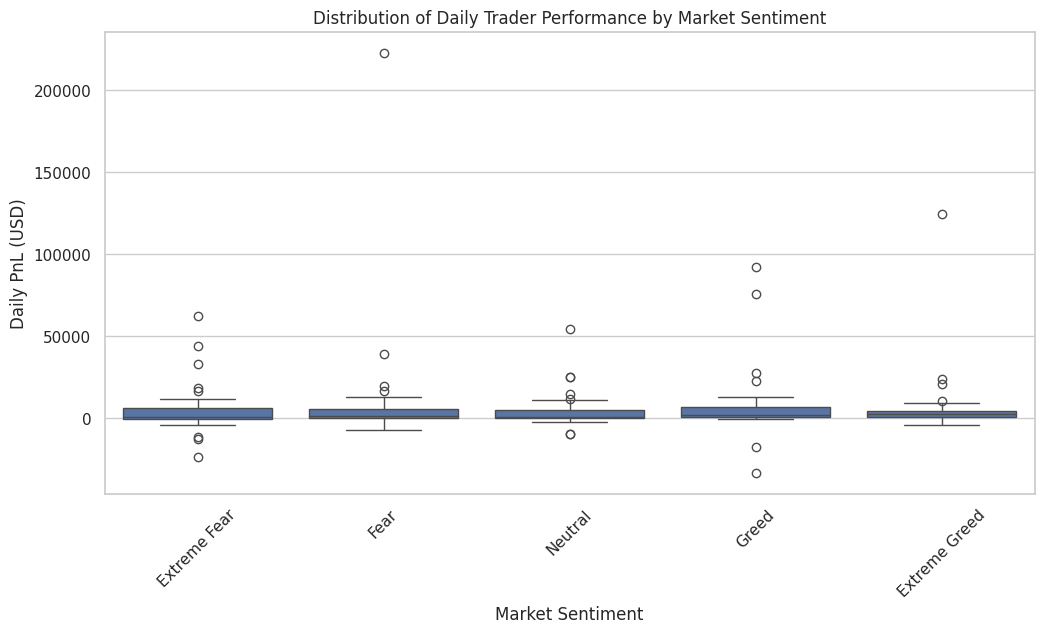

In [92]:
# Plot performance distribution by sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='classification', y='daily_pnl', data=top_traders,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Distribution of Daily Trader Performance by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Daily PnL (USD)')
plt.xticks(rotation=45)
plt.show()

In [93]:
# Classify trades by prevailing sentiment when opened
trader_data['entry_sentiment'] = pd.merge(
    trader_data,
    fear_greed[['date', 'classification']],
    left_on='date',
    right_on='date',
    how='left'
)['classification']

# Calculate strategy performance metrics by sentiment regime
strategy_metrics = trader_data.groupby(['Account', 'entry_sentiment']).agg({
    'Closed PnL': ['mean', 'std', 'count', lambda x: np.mean(x > 0)],  # Win rate
    'Size USD': 'mean'
}).reset_index()
strategy_metrics.columns = ['Account', 'Sentiment', 'Avg_PnL', 'PnL_StdDev', 'Trade_Count', 'Win_Rate', 'Avg_Size']

# Identify best performing strategies in each regime
top_strategies = strategy_metrics.sort_values(['Sentiment', 'Avg_PnL'], ascending=[True, False])
print("Top Performing Strategies by Sentiment Regime:")
display(top_strategies.groupby('Sentiment').head(3))

Top Performing Strategies by Sentiment Regime:


,Account,Sentiment,Avg_PnL,PnL_StdDev,Trade_Count,Win_Rate,Avg_Size
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Fear,1247.692214,11520.282899,100,0.370000,15071.008600
80,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,Extreme Fear,900.002541,3166.469923,221,0.420814,2613.952760
60,0x4f93fead39b70a1824f981a54d4e55b278e9f760,Extreme Fear,200.395004,682.349533,371,0.428571,25119.228652
46,0x430f09841d65beb3f27765503d0f850b8bce7713,Extreme Greed,8285.663252,9492.439479,15,1.000000,8285.689333
135,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Extreme Greed,672.735763,3090.800262,1643,0.510043,3141.527097
71,0x6d6a4b953f202f8df5bed40692e7fd865318264a,Extreme Greed,428.023843,1035.491061,171,0.894737,619.958304
42,0x420ab45e0bd8863569a5efbb9c05d91f40624641,Fear,1016.819167,3522.198965,98,0.357143,6300.139082
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,626.194346,4691.545889,1778,0.526434,17020.494876
82,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,Fear,335.300103,1227.936522,431,0.645012,1465.772506
78,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,Greed,764.916220,3792.423374,593,0.317032,8515.413980


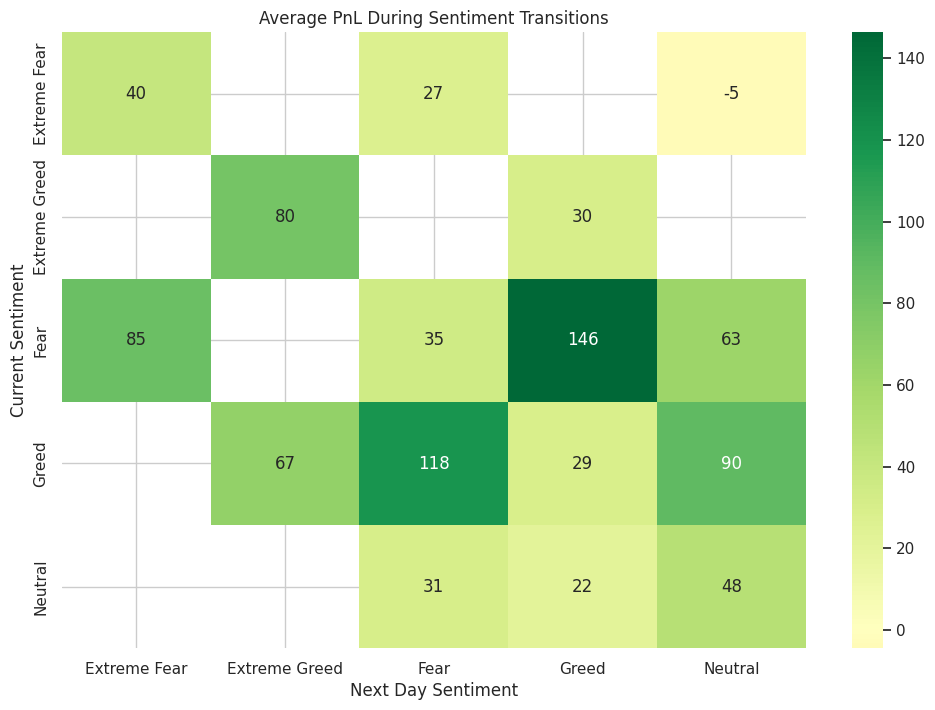

In [94]:
# Analyze how performance changes when sentiment shifts
fear_greed['next_sentiment'] = fear_greed['classification'].shift(-1)
transition_perf = pd.merge(
    trader_data,
    fear_greed[['date', 'classification', 'next_sentiment']],
    left_on='date',
    right_on='date',
    how='left'
)

# Performance during sentiment transitions
transition_matrix = transition_perf.groupby(['classification', 'next_sentiment'])['Closed PnL'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(transition_matrix, annot=True, fmt=".0f", cmap="RdYlGn", center=0)
plt.title('Average PnL During Sentiment Transitions')
plt.xlabel('Next Day Sentiment')
plt.ylabel('Current Sentiment')
plt.show()

In [95]:
# Calculate Value-at-Risk (VaR) by sentiment
def calculate_var(series, alpha=0.05):
    return np.percentile(series, alpha * 100)

sentiment_risk = trader_data.groupby('entry_sentiment')['Closed PnL'].agg([
    ('Avg_PnL', 'mean'),
    ('VaR_95', lambda x: calculate_var(x, 0.05)),
    ('CVaR_95', lambda x: x[x <= calculate_var(x, 0.05)].mean()),
    ('Max_Drawdown', lambda x: x.min())
]).reset_index()

print("Risk Metrics by Sentiment Regime:")
display(sentiment_risk.style.background_gradient(cmap='RdYlGn'))

Risk Metrics by Sentiment Regime:


,entry_sentiment,Avg_PnL,VaR_95,CVaR_95,Max_Drawdown
0,Extreme Fear,34.537862,-33.674459,-582.038127,-31036.691940
1,Extreme Greed,67.892861,-0.220510,-135.439246,-10259.468000
2,Fear,54.290400,-0.717115,-191.919988,-35681.747230
3,Greed,42.743559,-13.957308,-415.175197,-117990.104100
4,Neutral,34.307718,-5.340448,-205.321696,-24500.000000
